In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from df_utils import get_companies_list, get_X_y
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, \
                            precision_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest

#### Load the dataframe and companies with not too many nans

In [2]:
df, companies = get_companies_list(2)
# learner history parameters
nhist = 10
nfut = 2
totHist = int(3*365)

comp_dict = {}
for i, comp in enumerate(companies):
    comp_dict[comp] = get_X_y(df, comp, nfut, nhist, totHist)

#### Drop some columns:

In [3]:
X_orig, y, ysim = comp_dict[comp]
print(X_orig.columns.values)
print(y.columns.values)
print(ysim.columns.values)

include = ['c_oend_%', 'c_slow_%', 'c_shigh_%', 'change_Me', 'offer_sell_', 'offer_buy_'] #['c_shigh_', 'c_slow_', 'offer_sell_', 'offer_buy_', 'sales_low_', 'sales_high_']
cols_keep = [col for col in X_orig.columns if col[:-4] in include] 
y_cols = ['offer_end_change', 'sale_low_change', 'sale_high_change']

['offer_end_-01' 'offer_end_-02' 'offer_end_-03' 'offer_end_-04'
 'offer_end_-05' 'offer_end_-06' 'offer_end_-07' 'offer_end_-08'
 'offer_end_-09' 'offer_end_-10' 'offer_buy_-01' 'offer_buy_-02'
 'offer_buy_-03' 'offer_buy_-04' 'offer_buy_-05' 'offer_buy_-06'
 'offer_buy_-07' 'offer_buy_-08' 'offer_buy_-09' 'offer_buy_-10'
 'offer_sell_-01' 'offer_sell_-02' 'offer_sell_-03' 'offer_sell_-04'
 'offer_sell_-05' 'offer_sell_-06' 'offer_sell_-07' 'offer_sell_-08'
 'offer_sell_-09' 'offer_sell_-10' 'sales_low_-01' 'sales_low_-02'
 'sales_low_-03' 'sales_low_-04' 'sales_low_-05' 'sales_low_-06'
 'sales_low_-07' 'sales_low_-08' 'sales_low_-09' 'sales_low_-10'
 'sales_high_-01' 'sales_high_-02' 'sales_high_-03' 'sales_high_-04'
 'sales_high_-05' 'sales_high_-06' 'sales_high_-07' 'sales_high_-08'
 'sales_high_-09' 'sales_high_-10' 'change_Me_-01' 'change_Me_-02'
 'change_Me_-03' 'change_Me_-04' 'change_Me_-05' 'change_Me_-06'
 'change_Me_-07' 'change_Me_-08' 'change_Me_-09' 'change_Me_-10'
 'c_s

### Plot pictures:

In [4]:
def plot_sim(comp, ysim, ndays, *args):
    
    
    plt.figure(figsize = (12,6))
    x = pd.to_datetime(ysim.index, format = '%d.%m.%Y')[:ndays]
    yl = ysim['sales_low_000'].values[:ndays]
    yh = ysim['sales_high_000'].values[:ndays]
    #y = ysim['offer_end_prev'].values[:ndays]
    
    #plt.plot_date(x,y, linestyle = '-', marker = None)
    plt.fill_between(x,yl,yh, linestyle = '-')
    plt.ylabel('Sales lowest to highest filled')
    #[plt.gca().axvline(xi, alpha = .1) for xi in x]
    
    if len(args) == 3:
        pred, truth, col = [arg[:ndays] for arg in args]
        
        correct = pred & truth
        fp = pred & np.logical_not(truth)
        
        plt.scatter(x[correct], yh[correct], s = 40, alpha = .7, 
                    c = 'green', label = col + ' correct')
        plt.scatter(x[truth], yh[truth], s = 20, c = 'red', alpha = .2,
                    label = col + ' true')
        
    else:    
        plt.twinx()
        y2 = ysim['offer_end_change']*100
        plt.plot_date(x,y2, linestyle = '-', marker = None, color = 'red')
        plt.ylabel('Offer end percentage change')
    
    plt.legend(frameon = False)
    plt.title(comp, fontsize = 14)
    plt.show()
   

### Make estimator pipe

In [9]:
pipe_rf = Pipeline([('pol', PolynomialFeatures(degree = 2, interaction_only = True)),
                    ('var', VarianceThreshold()),
                    ('sel', SelectKBest()),
                    ('rf', RandomForestClassifier())]) 

params_rf = [{'sel__k': np.arange(40,100,10),
              'rf__max_features': np.arange(5,30,5),
              'rf__max_depth': [5,10,20],
              'rf__n_estimators': [20,50,100]}]

pipe_gbm = Pipeline([('pol', PolynomialFeatures(degree = 2, interaction_only = True)),
                     ('var', VarianceThreshold()),
                     ('sel', SelectKBest()),
                     ('gbm', GradientBoostingClassifier())]) 

params_gbm = [{'sel__k': np.arange(20,50,10),
               'gbm__learning_rate': np.linspace(.05,.4, 8),
               'gbm__max_depth': [3,5],
               'gbm__n_estimators': np.arange(50, 200, 25) }]


def get_pipe(key):
    if key == 'rf':
        return pipe_rf, params_rf
    elif key == 'gbm':
        return pipe_gbm, params_gbm


### Make custom fit for each company:

In [6]:
def comp_estimator(comp, y, threshold, pipe, params, ntest = 50, metric = 'roc_auc'):
    
    splitter = StratifiedKFold(n_splits = 5, shuffle = True) #, random_state = 0)
    X,_,ysim = comp_dict[comp]
    X = X[cols_keep]
    
    y_bin = threshold < y
    
    X_test, y_test = X[:ntest], y_bin[:ntest]
    X_train, y_train = X[ntest:], y_bin[ntest:]
    Xy = [X_train, X_test, y_train, y_test, ysim, y_bin]
    
    
    grid = GridSearchCV(pipe, params, scoring = metric, n_jobs = 5, 
                        cv = splitter, verbose = 1)
    grid.fit(X_train, y_train)
    
    return Xy, grid.best_estimator_, grid.best_params_, grid.best_score_


def get_scores(y_pred_train, y_pred_test, y_pred_train_p, 
               y_pred_test_p, y_train, y_test, show_report = False):
    try:
        roc_auc_test = roc_auc_score(y_test, y_pred_test_p)
    except ValueError as e:
        print(e)
        roc_auc_test = -1
    
    precision_test = precision_score(y_test, y_pred_test)
    
    if show_report:
        print('Train set classification')
        print(classification_report(y_train, y_pred_train, target_names = ['not rise', 'rise']))
        print(confusion_matrix(y_train, y_pred_train))
        print('Train roc_auc = {:.3f}'.format(roc_auc_score(y_train, y_pred_train_p)))
        print('\nTest set classification')
        print(classification_report(y_test, y_pred_test, target_names = ['not rise', 'rise']))
        print(confusion_matrix(y_test, y_pred_test))
        print('Test roc_auc = {:.3f}\n'.format(roc_auc_test))
    
    return roc_auc_test, precision_test

def get_prediction(Xy, estimator, show_report = False):
    
    X_train, X_test, y_train, y_test = Xy[:4]
    y_pred_train = estimator.predict(X_train)
    y_pred_test = estimator.predict(X_test)
    y_pred_train_p = estimator.predict_proba(X_train)[:,1]
    y_pred_test_p = estimator.predict_proba(X_test)[:,1]
    
    
    return y_pred_train, y_pred_test, y_pred_train_p, y_pred_test_p


### Feed the pipe to fit for each company and collect the results

In [7]:
def fit_and_report(companies, key = 'rf', ntest = 100, show = False):
    
    thres = {'offer_end_change':.0, 
             'sale_low_change+1':.0,
             'sale_low_change':.0,
             'sale_high_change':.0}
    
    pipe, params = get_pipe(key)
    
    try:
        results_dict = np.load('opm_params_{}.npy'.format(key)).item()        
    except FileNotFoundError:
        results_dict = {}
    
    for comp in companies:
        y = comp_dict[comp][1]
        for col in y.columns.values:
            try:
                results_dict[comp][col]
            except KeyError:
                
                
                print(comp, ' ', col)

                X,_,ysim = comp_dict[comp]
                X = X[cols_keep]

                Xy, estimator_r, params_opm_r, score_r \
                    = comp_estimator(comp, y[col].values,
                                     thres[col], pipe, params,
                                     ntest = ntest,
                                     metric = 'roc_auc')

                y_pred_train, y_pred_test, y_pred_train_p, y_pred_test_p \
                    = get_prediction(Xy, estimator_r)

                roc_auc, precision = get_scores(y_pred_train, 
                                                y_pred_test, 
                                                y_pred_train_p, 
                                                y_pred_test_p, 
                                                Xy[2], Xy[3], 
                                                show_report = show)

                if show:
                    print(params_opm_r)
                    y_pred_tot = np.concatenate((y_pred_test, 
                                                 y_pred_train))
                    plot_sim(comp, Xy[4], ntest*4, y_pred_tot, 
                             Xy[5], col)


                col_dict = {col: {'roc_auc':roc_auc, 
                                  'precision':precision,
                                  'threshold':thres[col],
                                  'opm_params':params_opm_r}}
                try:
                    results_dict[comp].update(col_dict)
                except KeyError:
                    results_dict[comp] = col_dict
                 
                np.save('opm_params_{}'.format(key), results_dict)
    return results_dict


    

Aktia Pankki A   offer_end_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   20.3s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   45.3s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       507
       rise       1.00      1.00      1.00       518

avg / total       1.00      1.00      1.00      1025

[[507   0]
 [  0 518]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.52      0.34      0.41        38
       rise       0.44      0.62      0.52        32

avg / total       0.49      0.47      0.46        70

[[13 25]
 [12 20]]
Test roc_auc = 0.486

{'gbm__learning_rate': 0.10000000000000001, 'gbm__max_depth': 5, 'gbm__n_estimators': 100, 'sel__k': 40}


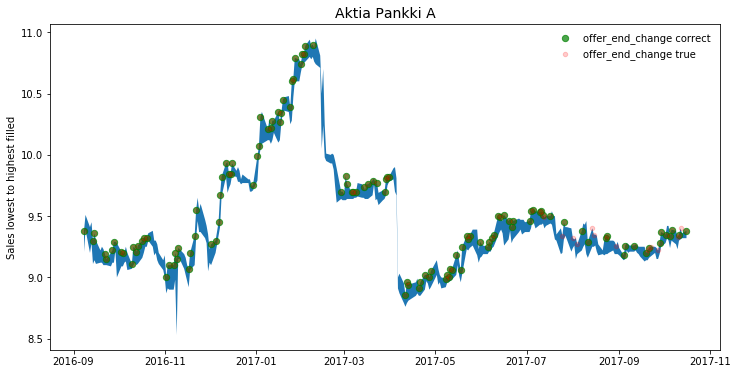

Aktia Pankki A   sale_low_change+1
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 235 tasks      | elapsed:   23.1s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:   49.8s
[Parallel(n_jobs=5)]: Done 835 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 1285 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.73      0.72      0.72       484
       rise       0.75      0.76      0.75       541

avg / total       0.74      0.74      0.74      1025

[[348 136]
 [131 410]]
Train roc_auc = 0.822

Test set classification
             precision    recall  f1-score   support

   not rise       0.55      0.46      0.50        37
       rise       0.49      0.58      0.53        33

avg / total       0.52      0.51      0.51        70

[[17 20]
 [14 19]]
Test roc_auc = 0.560

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__n_estimators': 50, 'sel__k': 20}


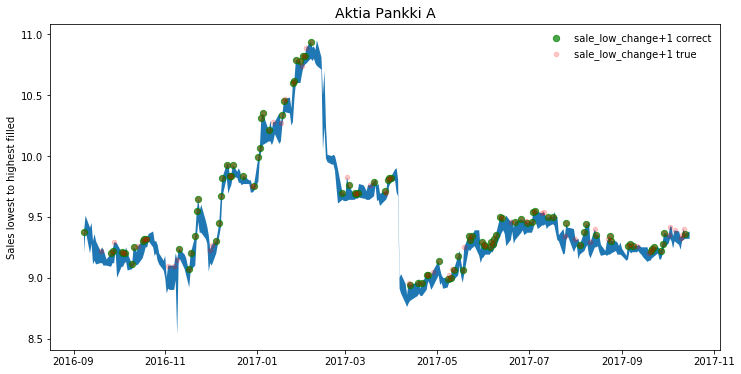

Aktia Pankki A   sale_low_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 236 tasks      | elapsed:   23.3s
[Parallel(n_jobs=5)]: Done 486 tasks      | elapsed:   49.4s
[Parallel(n_jobs=5)]: Done 836 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 1286 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.93      0.92      0.93       484
       rise       0.93      0.94      0.93       541

avg / total       0.93      0.93      0.93      1025

[[445  39]
 [ 33 508]]
Train roc_auc = 0.980

Test set classification
             precision    recall  f1-score   support

   not rise       0.58      0.49      0.53        37
       rise       0.51      0.61      0.56        33

avg / total       0.55      0.54      0.54        70

[[18 19]
 [13 20]]
Test roc_auc = 0.547

{'gbm__learning_rate': 0.35000000000000003, 'gbm__max_depth': 3, 'gbm__n_estimators': 50, 'sel__k': 20}


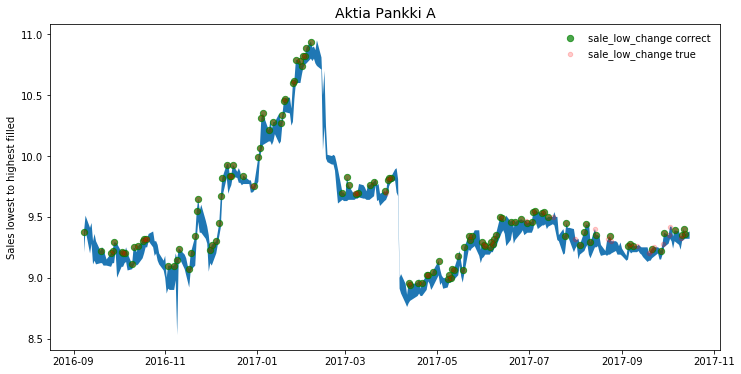

Aktia Pankki A   sale_high_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 242 tasks      | elapsed:   23.5s
[Parallel(n_jobs=5)]: Done 492 tasks      | elapsed:   50.2s
[Parallel(n_jobs=5)]: Done 842 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 1292 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.75      0.77      0.76       532
       rise       0.74      0.72      0.73       493

avg / total       0.74      0.74      0.74      1025

[[410 122]
 [140 353]]
Train roc_auc = 0.828

Test set classification
             precision    recall  f1-score   support

   not rise       0.74      0.48      0.58        42
       rise       0.49      0.75      0.59        28

avg / total       0.64      0.59      0.58        70

[[20 22]
 [ 7 21]]
Test roc_auc = 0.549

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__n_estimators': 50, 'sel__k': 20}


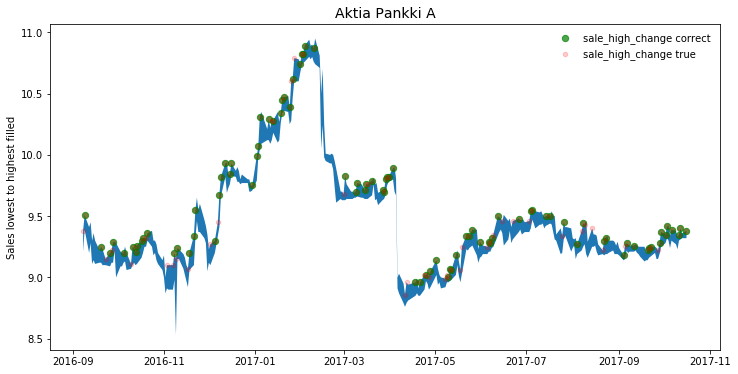

Alma Media   offer_end_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   19.2s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   42.9s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.5min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       549
       rise       1.00      1.00      1.00       476

avg / total       1.00      1.00      1.00      1025

[[549   0]
 [  0 476]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.63      0.60      0.61        45
       rise       0.33      0.36      0.35        25

avg / total       0.52      0.51      0.52        70

[[27 18]
 [16  9]]
Test roc_auc = 0.480

{'gbm__learning_rate': 0.29999999999999999, 'gbm__max_depth': 5, 'gbm__n_estimators': 175, 'sel__k': 40}


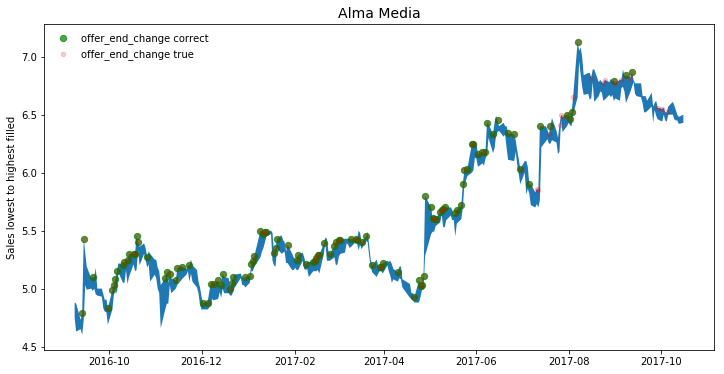

Alma Media   sale_low_change+1
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 259 tasks      | elapsed:   24.4s
[Parallel(n_jobs=5)]: Done 509 tasks      | elapsed:   51.3s
[Parallel(n_jobs=5)]: Done 859 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 1309 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.5min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       535
       rise       1.00      1.00      1.00       490

avg / total       1.00      1.00      1.00      1025

[[535   0]
 [  0 490]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.61      0.56      0.59        39
       rise       0.50      0.55      0.52        31

avg / total       0.56      0.56      0.56        70

[[22 17]
 [14 17]]
Test roc_auc = 0.543

{'gbm__learning_rate': 0.35000000000000003, 'gbm__max_depth': 5, 'gbm__n_estimators': 125, 'sel__k': 40}


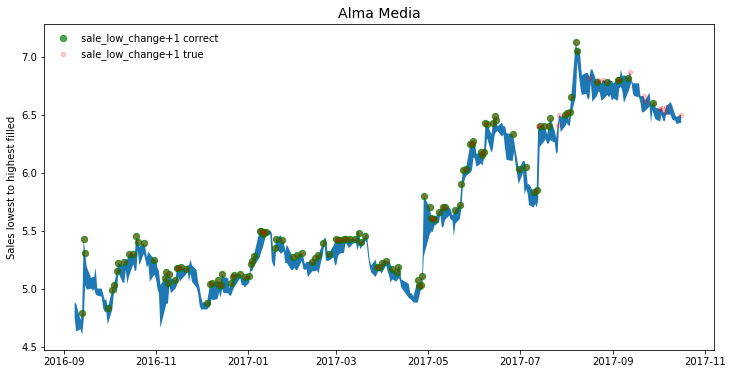

Alma Media   sale_low_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 259 tasks      | elapsed:   24.8s
[Parallel(n_jobs=5)]: Done 509 tasks      | elapsed:   51.5s
[Parallel(n_jobs=5)]: Done 859 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 1309 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.5min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.81      0.95      0.88       535
       rise       0.93      0.76      0.84       490

avg / total       0.87      0.86      0.86      1025

[[508  27]
 [116 374]]
Train roc_auc = 0.950

Test set classification
             precision    recall  f1-score   support

   not rise       0.59      0.67      0.63        39
       rise       0.50      0.42      0.46        31

avg / total       0.55      0.56      0.55        70

[[26 13]
 [18 13]]
Test roc_auc = 0.492

{'gbm__learning_rate': 0.10000000000000001, 'gbm__max_depth': 3, 'gbm__n_estimators': 75, 'sel__k': 30}


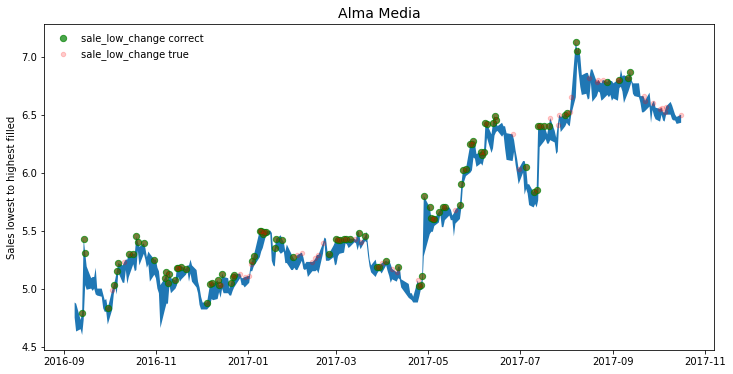

Alma Media   sale_high_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 237 tasks      | elapsed:   22.7s
[Parallel(n_jobs=5)]: Done 487 tasks      | elapsed:   48.2s
[Parallel(n_jobs=5)]: Done 837 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 1287 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.5min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.72      0.98      0.83       617
       rise       0.94      0.41      0.58       408

avg / total       0.81      0.76      0.73      1025

[[607  10]
 [239 169]]
Train roc_auc = 0.873

Test set classification
             precision    recall  f1-score   support

   not rise       0.54      0.87      0.67        39
       rise       0.29      0.06      0.11        31

avg / total       0.43      0.51      0.42        70

[[34  5]
 [29  2]]
Test roc_auc = 0.540

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__n_estimators': 50, 'sel__k': 40}


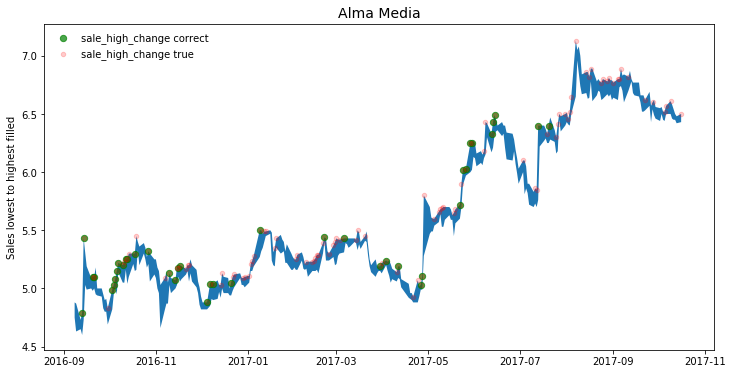

Amer Sports A   offer_end_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 230 tasks      | elapsed:   24.2s
[Parallel(n_jobs=5)]: Done 480 tasks      | elapsed:   52.7s
[Parallel(n_jobs=5)]: Done 830 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 1280 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.8min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       507
       rise       1.00      1.00      1.00       518

avg / total       1.00      1.00      1.00      1025

[[507   0]
 [  0 518]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.43      0.31      0.36        42
       rise       0.28      0.39      0.32        28

avg / total       0.37      0.34      0.35        70

[[13 29]
 [17 11]]
Test roc_auc = 0.389

{'gbm__learning_rate': 0.40000000000000002, 'gbm__max_depth': 5, 'gbm__n_estimators': 150, 'sel__k': 30}


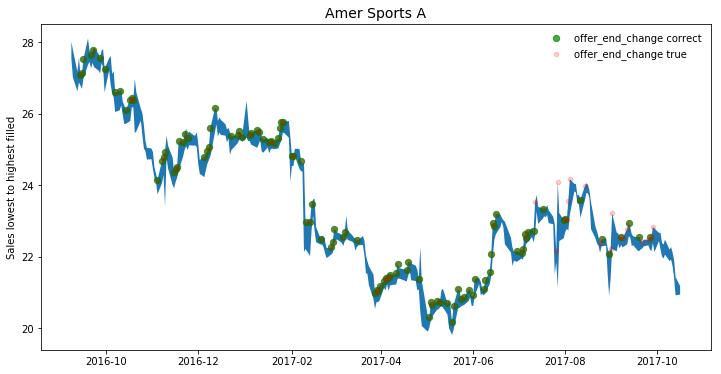

Amer Sports A   sale_low_change+1
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   21.9s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   49.1s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.8min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.70      0.82      0.75       511
       rise       0.78      0.65      0.71       514

avg / total       0.74      0.73      0.73      1025

[[420  91]
 [182 332]]
Train roc_auc = 0.828

Test set classification
             precision    recall  f1-score   support

   not rise       0.65      0.83      0.73        36
       rise       0.75      0.53      0.62        34

avg / total       0.70      0.69      0.68        70

[[30  6]
 [16 18]]
Test roc_auc = 0.709

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__n_estimators': 50, 'sel__k': 20}


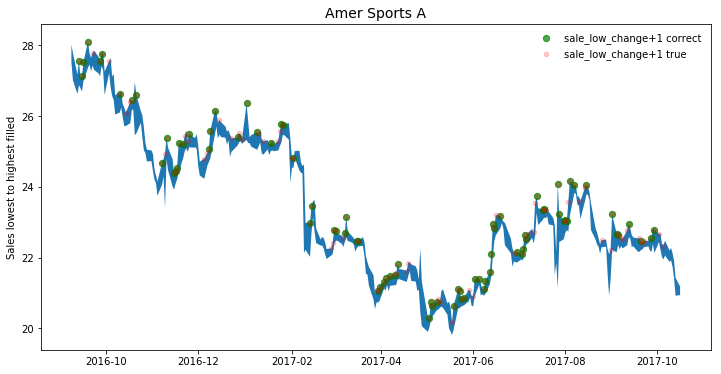

Amer Sports A   sale_low_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   21.6s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   48.6s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.8min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       511
       rise       1.00      1.00      1.00       514

avg / total       1.00      1.00      1.00      1025

[[511   0]
 [  2 512]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.65      0.67      0.66        36
       rise       0.64      0.62      0.63        34

avg / total       0.64      0.64      0.64        70

[[24 12]
 [13 21]]
Test roc_auc = 0.703

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 5, 'gbm__n_estimators': 150, 'sel__k': 40}


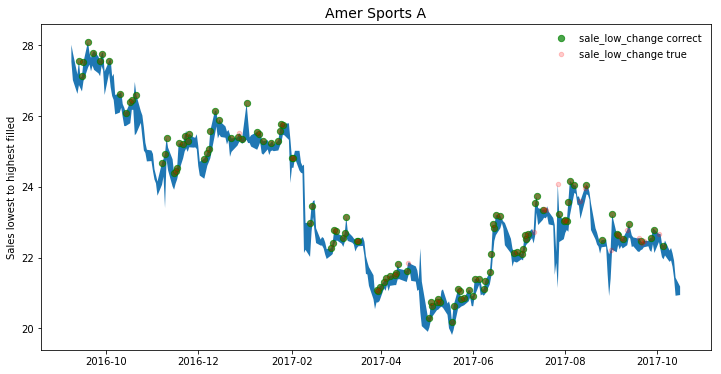

Amer Sports A   sale_high_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 235 tasks      | elapsed:   24.9s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:   52.9s
[Parallel(n_jobs=5)]: Done 835 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 1285 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.8min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.78      0.63      0.70       516
       rise       0.69      0.82      0.75       509

avg / total       0.73      0.72      0.72      1025

[[326 190]
 [ 92 417]]
Train roc_auc = 0.825

Test set classification
             precision    recall  f1-score   support

   not rise       0.81      0.63      0.71        46
       rise       0.50      0.71      0.59        24

avg / total       0.70      0.66      0.67        70

[[29 17]
 [ 7 17]]
Test roc_auc = 0.634

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__n_estimators': 50, 'sel__k': 20}


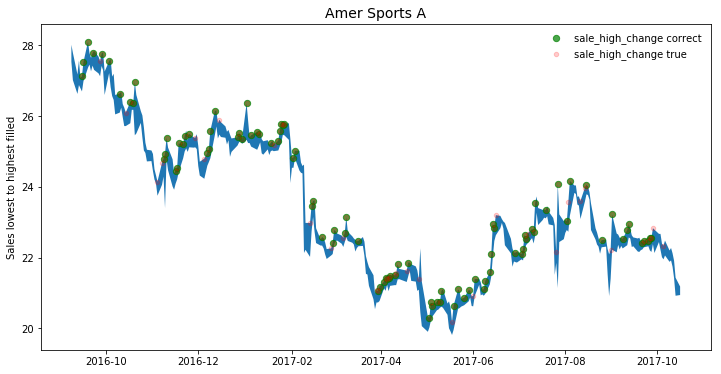

Aspo   offer_end_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 259 tasks      | elapsed:   24.7s
[Parallel(n_jobs=5)]: Done 509 tasks      | elapsed:   52.2s
[Parallel(n_jobs=5)]: Done 859 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 1309 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       515
       rise       1.00      1.00      1.00       510

avg / total       1.00      1.00      1.00      1025

[[515   0]
 [  1 509]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.51      0.51      0.51        35
       rise       0.51      0.51      0.51        35

avg / total       0.51      0.51      0.51        70

[[18 17]
 [17 18]]
Test roc_auc = 0.505

{'gbm__learning_rate': 0.10000000000000001, 'gbm__max_depth': 5, 'gbm__n_estimators': 150, 'sel__k': 30}


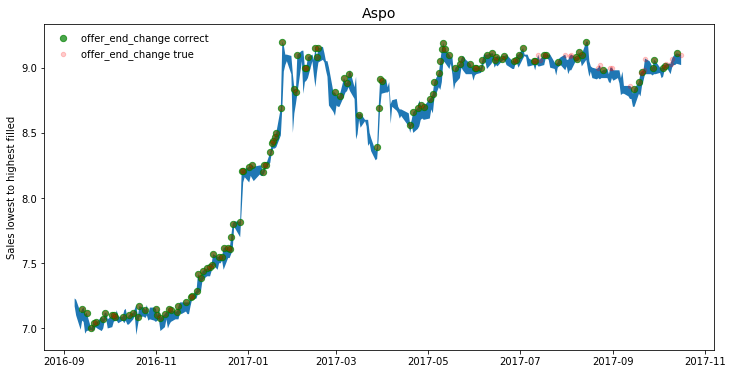

Aspo   sale_low_change+1
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 236 tasks      | elapsed:   23.0s
[Parallel(n_jobs=5)]: Done 486 tasks      | elapsed:   49.2s
[Parallel(n_jobs=5)]: Done 836 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 1286 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       478
       rise       1.00      1.00      1.00       547

avg / total       1.00      1.00      1.00      1025

[[478   0]
 [  0 547]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.53      0.44      0.48        39
       rise       0.42      0.52      0.46        31

avg / total       0.48      0.47      0.47        70

[[17 22]
 [15 16]]
Test roc_auc = 0.495

{'gbm__learning_rate': 0.25, 'gbm__max_depth': 5, 'gbm__n_estimators': 75, 'sel__k': 40}


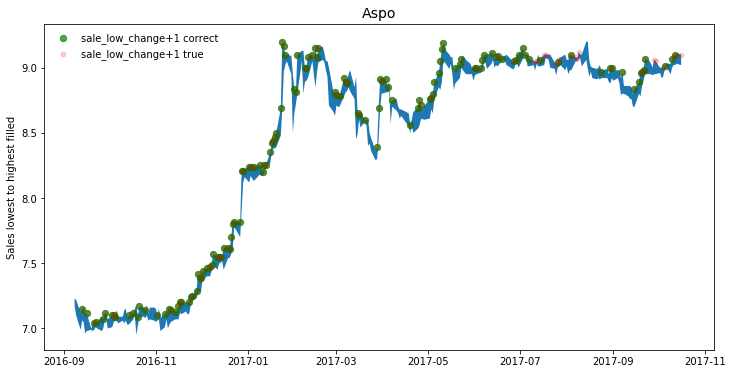

Aspo   sale_low_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 239 tasks      | elapsed:   23.8s
[Parallel(n_jobs=5)]: Done 489 tasks      | elapsed:   50.1s
[Parallel(n_jobs=5)]: Done 839 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 1289 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.74      0.76      0.75       478
       rise       0.78      0.77      0.78       547

avg / total       0.76      0.76      0.76      1025

[[363 115]
 [128 419]]
Train roc_auc = 0.843

Test set classification
             precision    recall  f1-score   support

   not rise       0.62      0.67      0.64        39
       rise       0.54      0.48      0.51        31

avg / total       0.58      0.59      0.58        70

[[26 13]
 [16 15]]
Test roc_auc = 0.631

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__n_estimators': 50, 'sel__k': 40}


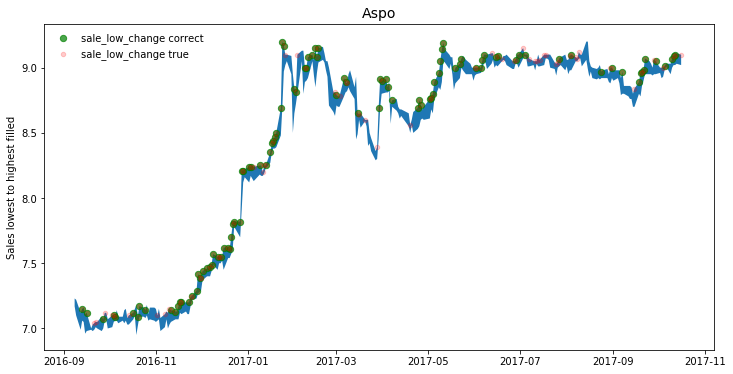

Aspo   sale_high_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 235 tasks      | elapsed:   23.3s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:   49.6s
[Parallel(n_jobs=5)]: Done 835 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 1285 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.87      0.90      0.88       558
       rise       0.87      0.83      0.85       467

avg / total       0.87      0.87      0.87      1025

[[502  56]
 [ 78 389]]
Train roc_auc = 0.958

Test set classification
             precision    recall  f1-score   support

   not rise       0.64      0.69      0.67        39
       rise       0.57      0.52      0.54        31

avg / total       0.61      0.61      0.61        70

[[27 12]
 [15 16]]
Test roc_auc = 0.572

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 5, 'gbm__n_estimators': 50, 'sel__k': 20}


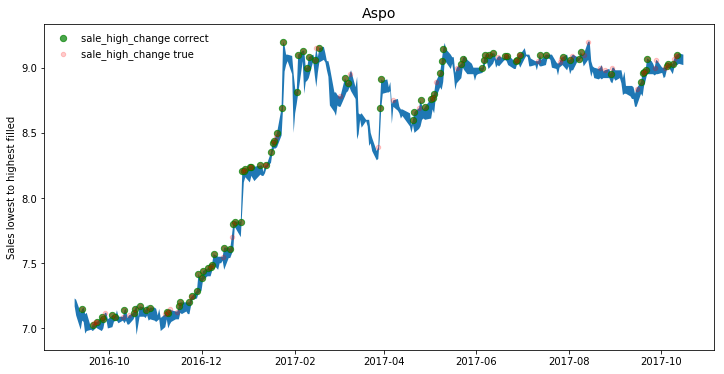

Atria A   offer_end_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   20.3s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   44.8s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.69      0.89      0.78       509
       rise       0.85      0.61      0.71       516

avg / total       0.77      0.75      0.74      1025

[[451  58]
 [199 317]]
Train roc_auc = 0.847

Test set classification
             precision    recall  f1-score   support

   not rise       0.56      0.79      0.66        34
       rise       0.68      0.42      0.52        36

avg / total       0.62      0.60      0.59        70

[[27  7]
 [21 15]]
Test roc_auc = 0.567

{'gbm__learning_rate': 0.050000000000000003, 'gbm__max_depth': 3, 'gbm__n_estimators': 50, 'sel__k': 30}


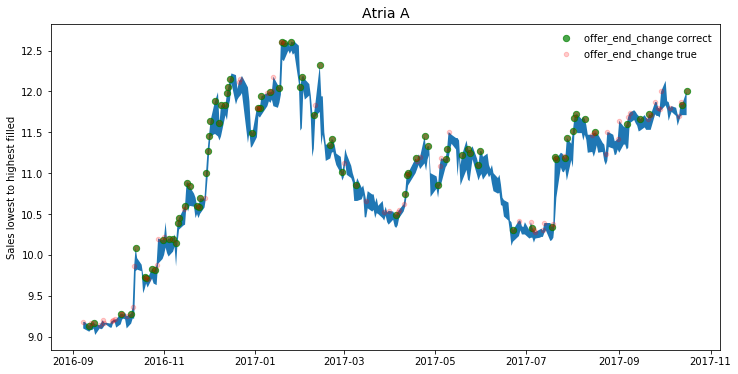

Atria A   sale_low_change+1
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   19.8s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   44.6s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       507
       rise       1.00      1.00      1.00       518

avg / total       1.00      1.00      1.00      1025

[[507   0]
 [  2 516]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.61      0.59      0.60        34
       rise       0.62      0.64      0.63        36

avg / total       0.61      0.61      0.61        70

[[20 14]
 [13 23]]
Test roc_auc = 0.657

{'gbm__learning_rate': 0.40000000000000002, 'gbm__max_depth': 3, 'gbm__n_estimators': 150, 'sel__k': 20}


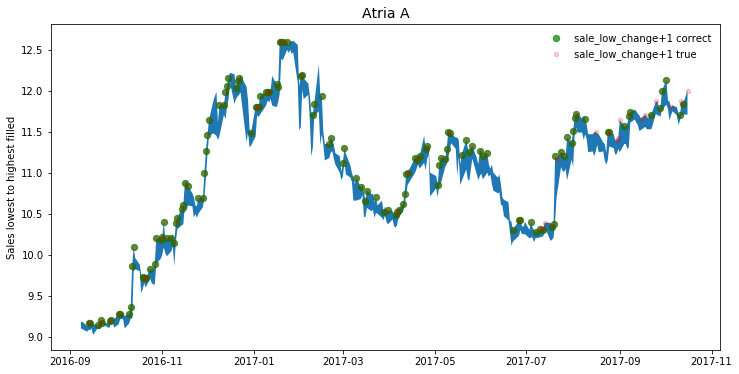

Atria A   sale_low_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   19.7s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   44.3s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.6min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       507
       rise       1.00      1.00      1.00       518

avg / total       1.00      1.00      1.00      1025

[[507   0]
 [  0 518]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.57      0.62      0.59        34
       rise       0.61      0.56      0.58        36

avg / total       0.59      0.59      0.59        70

[[21 13]
 [16 20]]
Test roc_auc = 0.645

{'gbm__learning_rate': 0.35000000000000003, 'gbm__max_depth': 5, 'gbm__n_estimators': 75, 'sel__k': 40}


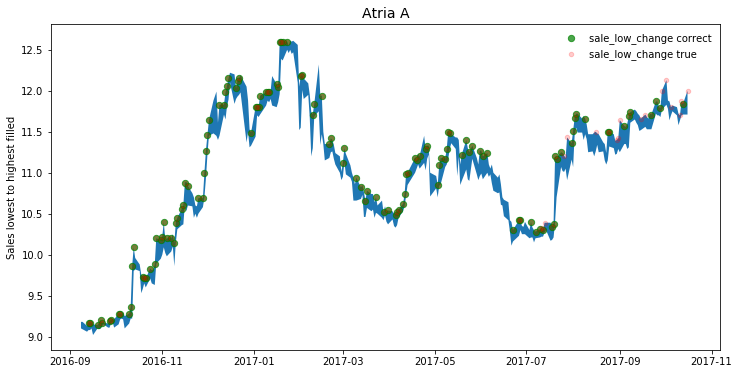

Atria A   sale_high_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 235 tasks      | elapsed:   23.5s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:   50.2s
[Parallel(n_jobs=5)]: Done 835 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 1285 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1440 out of 1440 | elapsed:  2.7min finished


Train set classification
             precision    recall  f1-score   support

   not rise       0.97      0.97      0.97       528
       rise       0.97      0.97      0.97       497

avg / total       0.97      0.97      0.97      1025

[[514  14]
 [ 17 480]]
Train roc_auc = 0.997

Test set classification
             precision    recall  f1-score   support

   not rise       0.36      0.38      0.37        34
       rise       0.38      0.36      0.37        36

avg / total       0.37      0.37      0.37        70

[[13 21]
 [23 13]]
Test roc_auc = 0.369

{'gbm__learning_rate': 0.35000000000000003, 'gbm__max_depth': 3, 'gbm__n_estimators': 75, 'sel__k': 20}


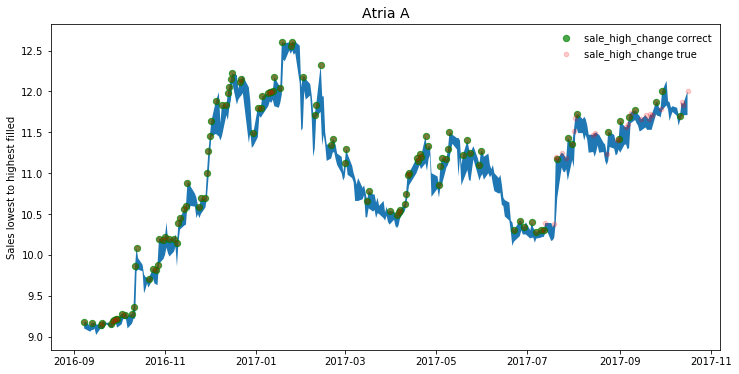

Basware   offer_end_change
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 236 tasks      | elapsed:   24.5s
[Parallel(n_jobs=5)]: Done 486 tasks      | elapsed:   52.4s


In [ ]:
method_key = 'gbm'
results_dict = fit_and_report(companies, method_key, ntest = 70, show = True)

## Then test the obtained results:
### First make the prediction dataframe

In [13]:
# optimal parameters:
opm_params = np.load('opm_params_{}.npy'.format(method_key)).item()


def get_predictions(ntest, comp, col):
    
    X, y, ysim = comp_dict[comp]
    X = X[cols_keep]
    
    y_bin = opm_params[comp][col]['threshold'] < y[col]    
    X_test, y_test = X[:ntest], y_bin[:ntest]
    X_train, y_train = X[ntest:], y_bin[ntest:]
    
    pipe, _ = get_pipe(method_key)
    pipe.set_params(**opm_params[comp][col]['opm_params']) 
    pipe.fit(X_train, y_train)
    
    return pipe.predict(X_test)

def get_prediction_df(ntest):
    idx_tuples = [(comp, col) for comp in companies for col in y.columns]
    index = pd.MultiIndex.from_tuples(idx_tuples)
    
    
    pred_df = pd.DataFrame(index = comp_dict['Alma Media'][0].index[:ntest], columns = index)
    
    for comp in companies:
        ysim = comp_dict[comp][-1]

        for col in y.columns:
            pred_df[(comp, col)] = get_predictions(ntest, comp, col) #np.zeros(ntest)
        
        pred_df[(comp, 'sales_low_prev')] = ysim['sales_low_prev']
        pred_df[(comp, 'sales_high_prev')] = ysim['sales_high_prev']
        
        pred_df[(comp, 'sales_low_000'.format(nfut-1))] = ysim['sales_low_000'.format(nfut-1)]
        pred_df[(comp, 'sales_high_{:03d}'.format(nfut-1))] = ysim['sales_high_{:03d}'.format(nfut-1)]
        pred_df[(comp, 'offer_end_{:03d}'.format(nfut-1))] = ysim['offer_end_{:03d}'.format(nfut-1)]
    pred_df.index = comp_dict[comp][0].index.values[:ntest]
    return pred_df

df_pred = get_prediction_df(100) 


In [19]:
def simulate(pred_df):
    
    # Defines the condition when stock is bought
    buy_condition = {'sale_low_change+1':False, 'sale_high_change':True}
    fact = 1.

    for day in df_pred.index[::-1]:
        for comp in companies:
            # Condition to buy:
            if all([pred_df.loc[day, comp][key] == val for key,val in buy_condition.items()]):
                # Make sure today sale low is smaller than yesterday:
                buy_price = None
                sell_price = None
                if pred_df.loc[day, comp]['sales_low_000'] < pred_df.loc[day, comp]['sales_low_prev']:
                    buy_price = pred_df.loc[day, comp]['sales_low_prev']
                if pred_df.loc[day, comp]['sales_high_prev'.format(nfut-1)] \
                    < pred_df.loc[day, comp]['sales_high_{:03d}'.format(nfut-1)]: 
                    sell_price = pred_df.loc[day, comp]['sales_high_{:03d}'.format(nfut-1)]
                    
                else:
                    sell_price = pred_df.loc[day, comp]['offer_end_{:03d}'.format(nfut-1)]
                    print('Fell', buy_price, sell_price)
                if not any([buy_price == None, sell_price == None]):
                    fact *= 1 + (sell_price - buy_price)/buy_price
                    print(fact)
                    print()
simulate(df_pred)

Fell 3.53 3.52
0.99716713881

Fell 45.07 43.31
0.95822739698

Fell 43.27 43.17
0.956012866365

Fell None 8.64
Fell 7.88 7.85
0.952373223473

Fell 23.79 23.66
0.947168998208

Fell 1.76 1.77
0.952550640243

Fell None 5.78
Fell 25.35 25.45
0.956308236457

Fell 35.0 34.5
0.942646690222

Fell 9.85 9.89
0.946474697086

0.967100053681

Fell 40.0 40.0
0.967100053681

Fell 11.0 11.02
0.968858417415

0.98567887605

Fell None 6.13
Fell 39.4 39.72
0.993684389765

